In [1]:
import pandas as pd
import ir_measures
import ir_datasets
from autoqrels.oneshot import OneShotLabeler
from sklearn.metrics import precision_recall_curve, average_precision_score
from matplotlib import pyplot as plt
import matplotlib.patches as patches

In [2]:
dataset = ir_datasets.load('msmarco-passage/trec-dl-2019/judged')
SYSTEMS = [
    ('BM25-MR', OneShotLabeler('maxrep.bm25-128.cache.json.gz'),   True,  -18),
    ('TCT-MR',  OneShotLabeler('maxrep.tcthnp-128.cache.json.gz'), False, -27),
    ('DuoT5',   OneShotLabeler('duot5.cache.json.gz'),             False, -38),
    ('DuoP',    OneShotLabeler('duoprompt.cache.json.gz'),         True,  -33),
]

In [3]:
qdid = lambda df: df['query_id'] + '\t' + df['doc_id']
full_qrels = pd.DataFrame(dataset.qrels)
full_qrels['relevance'] = (full_qrels['relevance'] >= 2).astype(int) # binarize
sparse_qrels = pd.DataFrame(ir_measures.read_trec_qrels('dl19.bm25-firstrel.qrels'))
missing_qrels = full_qrels[~qdid(full_qrels).isin(qdid(sparse_qrels))]
missing_qrels = missing_qrels[missing_qrels['query_id'].isin(sparse_qrels['query_id'])]

/var/folders/ym/j8hjx6nd50g_ccj4j5hmgy7m0000gn/T/ipykernel_22238/1091496818.py:20: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * p * r / (p + r)


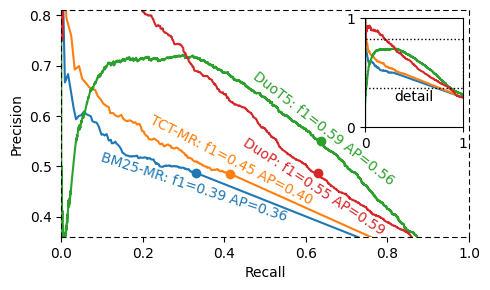

In [4]:
fig, ax = plt.subplots(figsize=(5,5*0.6))
ax.set_xlim(0, 1)
ax.set_xlabel('Recall')
ax.set_ylim(0.36, 0.81)
ax.set_ylabel('Precision')
inset_scale = 0.48
axins = ax.inset_axes([1-inset_scale/2-0.015, 1-inset_scale-0.035, inset_scale/2, inset_scale])
axins.set_xlim(0, 1) ; axins.set_xticks([0, 1])
axins.set_ylim(0, 1) ; axins.set_yticks([0, 1])
for name, model, under, rot in SYSTEMS:
    inf_qrels = model.infer_qrels(missing_qrels, sparse_qrels)
    inf_qrel_map = {}
    for rec in inf_qrels.itertuples(index=False):
        inf_qrel_map[rec.query_id, rec.doc_id] = rec.relevance
    label, pred = [], []
    for qid, did, rel in zip(missing_qrels['query_id'], missing_qrels['doc_id'], missing_qrels['relevance']):
        label.append(rel)
        pred.append(inf_qrel_map[qid, did])
    p, r, _ = precision_recall_curve(label, pred)
    f1 = 2 * p * r / (p + r)
    mx = f1[2:-2].argmax() + 2 # f1 score undefined at bounds? Correct this.
    f1 = f1[mx]
    ap = average_precision_score(label, pred)
    l = ax.plot(r, p, label=name)
    axins.plot(r, p)
    plt.plot(r[mx], p[mx], 'o', c=l[0].get_color())
    if under:
        ax.annotate('{}: f1={:.2f} AP={:.2f}'.format(name, f1, ap), (r[mx], p[mx]-0.015), ha='center', va='top', c=l[0].get_color(), rotation=rot, rotation_mode='anchor')
    else:
        ax.annotate('{}: f1={:.2f} AP={:.2f}'.format(name, f1, ap), (r[mx], p[mx]+0.02), ha='center', c=l[0].get_color(), rotation=rot, rotation_mode='anchor')
ax.spines['top'].set_linestyle((0,(4,4)))
ax.spines['left'].set_linestyle((0,(4,4)))
ax.spines['bottom'].set_linestyle((0,(4,4)))
ax.spines['right'].set_linestyle((0,(4,4)))
axins.add_patch(patches.Rectangle((0.0, 0.36), 1.0, 0.45, linewidth=1, edgecolor='k',  facecolor='none', ls=':', zorder=100))
axins.annotate('detail', (0.5, 0.34), ha='center', va='top')
plt.tight_layout()
plt.savefig('figure1.pdf')